<a href="https://colab.research.google.com/github/LyanhVini/EstimativaTrajetoriaICP-LiDAR-KITTI/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uma tarefa que lidamos comumente é trabalhar com nuvens de pontos (point clouds). As point clouds são
dados que podem ser extraídos de formas diferentes: um par de câmeras (geometria estéreo), sensor LiDAR
(Light Detection And Ranging), sensores de profundidade e etc. Nessa tarefa, você receberá um conjunto de 30
scans extraídos de um LiDAR, estes dados são parte do KITTI DATASET. Utilize as point clouds de cada scan
para estimar a trajetória final do veículo, de forma que essa trajetória se inicie no primeiro scan. Para estimar
a trajetória percorrida pelo carro você deve usar o algoritmo Iterative Closest-Points (ICP). Contudo, você não
pode utilizar bibliotecas de terceiros para isso. Você deve fazer sua própria implementação do
algoritmo ICP. Em seu código, você deve mostrar que sua implementação está correta. Além disso, estamso
anexando a ground-truth que é um arquivo .npy, que pode ser aberto com a biblioteca NumPy. Ao carregá-lo,
você terá um array de tamanho (30, 4, 4). Cada linha, primeiro indice, representa uma matriz de
transformação em coordenadas homogêneas para cada uma das 30 posições do carro.


## Preparando o Ambiente

In [ ]:
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 6.5 MB/s eta 0:00:00


In [ ]:
import trimesh
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt

## Carregando e analisando os dados KITTI DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir KITTI-Sequence

!unzip /content/drive/MyDrive/IA/datasets/KITTI-Sequence.zip -d KITTI-Sequence

Archive:  /content/drive/MyDrive/IA/datasets/KITTI-Sequence.zip
   creating: KITTI-Sequence/000000/
  inflating: KITTI-Sequence/000000/000000_points.obj  
   creating: KITTI-Sequence/000001/
  inflating: KITTI-Sequence/000001/000001_points.obj  
   creating: KITTI-Sequence/000002/
  inflating: KITTI-Sequence/000002/000002_points.obj  
   creating: KITTI-Sequence/000003/
  inflating: KITTI-Sequence/000003/000003_points.obj  
   creating: KITTI-Sequence/000004/
  inflating: KITTI-Sequence/000004/000004_points.obj  
   creating: KITTI-Sequence/000005/
  inflating: KITTI-Sequence/000005/000005_points.obj  
   creating: KITTI-Sequence/000006/
  inflating: KITTI-Sequence/000006/000006_points.obj  
   creating: KITTI-Sequence/000007/
  inflating: KITTI-Sequence/000007/000007_points.obj  
   creating: KITTI-Sequence/000008/
  inflating: KITTI-Sequence/000008/000008_points.obj  
   creating: KITTI-Sequence/000009/
  inflating: KITTI-Sequence/000009/000009_points.obj  
   creating: KITTI-Sequenc

In [ ]:
print("===========00===========")
point_cloud00 = trimesh.load("/content/KITTI-Sequence/000000/000000_points.obj").vertices
print(point_cloud00)
print(point_cloud00.shape)

print("===========01===========")

point_cloud01 = trimesh.load("/content/KITTI-Sequence/000001/000001_points.obj").vertices
print(point_cloud01)
print(point_cloud01.shape)

print("===========02===========")
point_cloud05 = trimesh.load("/content/KITTI-Sequence/000005/000005_points.obj").vertices
print(point_cloud05)
print(point_cloud05.shape)

===========00===========
[[-9.110238 18.638599  0.909355]
 [-9.151207 18.5732    0.908344]
 [-9.206173 18.536804  0.908331]
 ...
 [ 1.438176  3.840138 -1.773556]
 [ 1.419202  3.825716 -1.76457 ]
 [ 1.507196  4.092375 -1.895561]]
(62553, 3)
===========01===========
[[-9.056182 17.949978  0.888338]
 [-9.106149 17.908581  0.887326]
 [-9.184107 17.92219   0.889309]
 ...
 [ 1.426188  3.824943 -1.765563]
 [ 1.42221   3.849532 -1.775574]
 [ 1.414232  3.863128 -1.780585]]
(62340, 3)
===========02===========
[[-8.764503 15.215836  0.802563]
 [-8.806476 15.177437  0.802554]
 [-8.823463 15.151237  0.801549]
 ...
 [ 1.431568  3.838956 -1.772774]
 [ 1.428578  3.848749 -1.776779]
 [ 1.416599  3.853324 -1.77679 ]]
(61375, 3)


In [ ]:
# Separar as coordenadas x, y e z dos pontos
x = point_cloud00[:, 0]
y = point_cloud00[:, 1]
z = point_cloud00[:, 2]

x1 = point_cloud01[:, 0]
y1 = point_cloud01[:, 1]
z1 = point_cloud01[:, 2]

x2 = point_cloud05[:, 0]
y2 = point_cloud05[:, 1]
z2 = point_cloud05[:, 2]

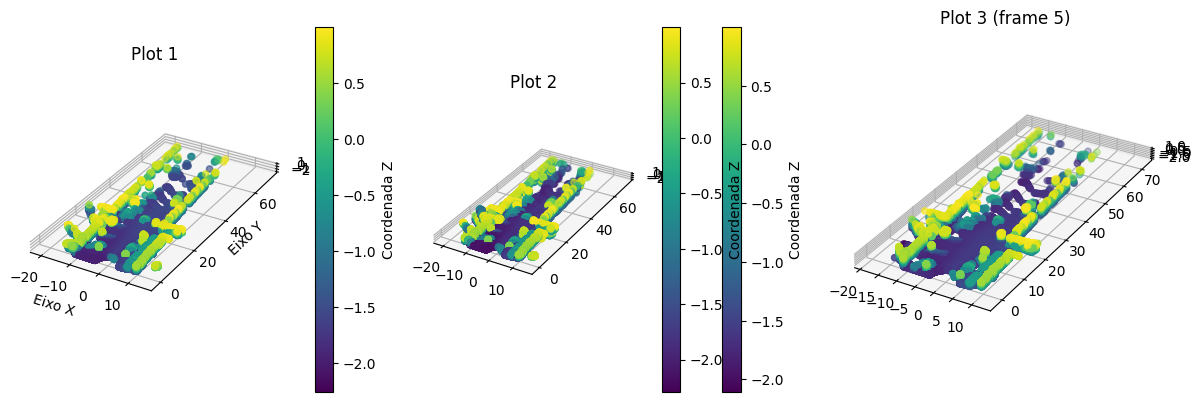

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 4))

# Primeiro subplot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter3D(x, y, z, c=z, cmap='viridis', s=20)
ax1.set_xlabel('Eixo X')
ax1.set_ylabel('Eixo Y')
ax1.set_zlabel('Eixo Z')
ax1.set_title('Plot 1')
ax1.set_box_aspect([np.ptp(x), np.ptp(y), np.ptp(z)]) # deixando os eixos proporcionais
cbar = fig.colorbar(ax1.scatter3D(x, y, z, c=z, cmap='viridis', s=20), ax=ax1)
cbar.set_label('Coordenada Z')

# Segundo subplot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter3D(x1, y1, z1, c=z1, cmap='viridis', s=20)

ax2.set_title('Plot 2')
ax2.set_box_aspect([np.ptp(x1), np.ptp(y1), np.ptp(z1)]) # deixar os eixos proporcionais
cbar = fig.colorbar(ax2.scatter3D(x1, y1, z1, c=z1, cmap='viridis', s=20), ax=ax2)
cbar.set_label('Coordenada Z')

# Terceiro subplot
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter3D(x2, y2, z2, c=z2, cmap='viridis', s=20)
ax3.set_title('Plot 3 (frame 5)')
ax3.set_box_aspect([np.ptp(x2), np.ptp(y2), np.ptp(z2)]) # deixar os eixos proporcionais
cbar = fig.colorbar(ax2.scatter3D(x2, y2, z2, c=z2, cmap='viridis', s=20), ax=ax2)
cbar.set_label('Coordenada Z')

# Ajustando os subplots
plt.tight_layout()
plt.show()

## Aplicando o Algoritmo ICP

### Iniciando as Funções Necessárias para o algoritmo

In [ ]:
from scipy.spatial import cKDTree

def load_point_cloud(file_path):
    """
    Função para carregar a nuvem de pontos de um arquivo .obj
    """
    import trimesh
    mesh = trimesh.load(file_path)
    return mesh.vertices

def find_correspondences(scan_referencia, scan_atual, max_distancia=0.1):
    # Implemente a lógica para encontrar correspondências entre scan_referencia e scan_atual.
    # Pode usar a função correspondencias_entre_scans que criamos anteriormente.
    correspondencias = correspondencias_entre_scans(scan_referencia, scan_atual, max_distancia)
    return correspondencias

In [ ]:
import numpy as np
from scipy.spatial import cKDTree

def correspondencias_entre_scans(referencia, scan_atual, max_distancia=0.1):
    """
    Encontra correspondências entre dois scans usando uma distância máxima dada.

    Parâmetros:
    - referencia: A nuvem de pontos de referência (numpy array de shape (n, 3)).
    - scan_atual: O scan que queremos encontrar correspondências (numpy array de shape (m, 3)).
    - max_distancia: A distância máxima permitida para considerar um ponto como correspondência.

    Retorna:
    - correspondencias: Uma lista de pares (índice_referencia, índice_scan_atual)
      que indicam as correspondências entre os pontos das duas nuvens de pontos.
    """
    # Construa uma árvore KD para a nuvem de pontos de referência para pesquisas eficientes
    tree_referencia = cKDTree(referencia)

    # Encontre correspondências usando a árvore KD
    correspondencias = []
    for i, ponto in enumerate(scan_atual):
        # Consulte os pontos mais próximos na nuvem de pontos de referência
        distancias, indices_referencia = tree_referencia.query(ponto, k=1)

        # Verifique se a distância está dentro do limite
        if distancias < max_distancia:
            correspondencias.append((indices_referencia, i))

    return correspondencias


In [ ]:
from scipy.spatial.transform import Rotation

def estimate_rigid_transform(scan_referencia, scan_atual, max_distancia=0.1):
    correspondencias = find_correspondences(scan_referencia, scan_atual, max_distancia)

    # Converter as correspondências em arrays numpy
    correspondencias = np.array(correspondencias)

    # Executar o algoritmo RANSAC para estimar a matriz de transformação
    num_iterations = 1000
    max_distance = 0.1  # Distância máxima para considerar uma correspondência como inlier
    best_inliers = None
    best_transform = None

    for i in range(num_iterations):
        # Escolher aleatoriamente 3 correspondências para estimar a matriz de transformação
        indices = np.random.choice(len(correspondencias), size=3, replace=False)
        src_sample = correspondencias[indices, 0:3]  # As 3 primeiras colunas são as coordenadas de origem
        dst_sample = correspondencias[indices, 3:6]  # As 3 últimas colunas são as coordenadas de destino

        # Calcular a matriz de transformação usando a técnica dos Mínimos Quadrados
        transform = estimate_transform(src_sample, dst_sample)

        # Calcular a distância entre os pontos correspondentes usando a matriz de transformação
        src_points = correspondencias[:, 0:3]
        dst_points = correspondencias[:, 3:6]
        distances = np.linalg.norm(dst_points - apply_transform(src_points, transform), axis=1)

        # Encontrar os índices dos inliers (correspondências que se encaixam no modelo)
        inliers = np.where(distances < max_distance)[0]

        # Verificar se essa estimativa possui mais inliers que a melhor estimativa anterior
        if best_inliers is None or len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_transform = transform

    # Calcular a matriz de transformação final usando todos os inliers encontrados
    best_src_points = correspondencias[best_inliers, 0:3]
    best_dst_points = correspondencias[best_inliers, 3:6]
    best_transform = estimate_transform(best_src_points, best_dst_points)

    return best_transform

def estimate_transform(src_points, dst_points):
    """
    Calcular a matriz de transformação rígida (rotação e translação) que mapea os pontos
    de origem (src_points) e destino (dst_points), respectivamente
    """
    src_centered = src_points - np.mean(src_points, axis=0)
    dst_centered = dst_points - np.mean(dst_points, axis=0)

    covariance_matrix = src_centered.T @ dst_centered
    u, _, vh = np.linalg.svd(covariance_matrix)
    rotation_matrix = vh.T @ u.T

    translation = np.mean(dst_points, axis=0) - np.mean(src_points @ rotation_matrix.T, axis=0)

    transform_matrix = np.eye(4)
    transform_matrix[:3, :3] = rotation_matrix
    transform_matrix[:3, 3] = translation

    return transform_matrix

def apply_transform(points, transform):
    """
    Aplica uma transformação rígida (rotação e translação) a um conjunto de pontos.
    """
    homogenous_points = np.column_stack((points, np.ones(len(points))))
    transformed_points = np.dot(homogenous_points, transform.T)
    return transformed_points[:, :3]

### Chamando as funções e executando o algoritmo ICP nos dados

In [ ]:
result = []

caminho_pasta_pai = '/content/KITTI-Sequence'

# Lista para armazenar as nuvens de pontos de X (inicio) e Y (destino) da trajetória
X_list = []
Y_list = []

# Loop para percorrer as subpastas dentro da pasta pai
subpastas = sorted(os.listdir(caminho_pasta_pai))
for i, subpasta in enumerate(subpastas[:-1]):  # Iterar até a penúltima subpasta
    caminho_pasta_atual = os.path.join(caminho_pasta_pai, subpasta)
    caminho_pasta_proxima = os.path.join(caminho_pasta_pai, subpastas[i + 1])

    # Loop para carregar e processar os arquivos .obj em X
    conteudo_pasta_atual = os.listdir(caminho_pasta_atual)
    pontos_x = []
    for arquivo in conteudo_pasta_atual:
        caminho_arquivo = os.path.join(caminho_pasta_atual, arquivo)
        pontos = load_point_cloud(caminho_arquivo)
        pontos_x.append(pontos)
    X_list.append(pontos_x)

    # Loop para carregar e processar os arquivos .obj em Y
    conteudo_pasta_proxima = os.listdir(caminho_pasta_proxima)
    pontos_y = []
    for arquivo in conteudo_pasta_proxima:
        caminho_arquivo = os.path.join(caminho_pasta_proxima, arquivo)
        pontos = load_point_cloud(caminho_arquivo)
        pontos_y.append(pontos)
    Y_list.append(pontos_y)

# Converter as listas em matrizes numpy
    X = np.vstack([np.vstack(pontos_x) for pontos_x in X_list])
    Y = np.vstack([np.vstack(pontos_y) for pontos_y in Y_list])

# Encontrando correspondências entre as nuvens de pontos X e Y
    correspondences = correspondencias_entre_scans(caminho_pasta_atual, caminho_pasta_proxima)
# Estimando a matriz de transformação rígida usando o algoritmo RANSAC
    transform_matrix = estimate_rigid_transform(correspondences)

# Resultados
    result.append(transform_matrix)

In [ ]:
import os
import numpy as np

def load_point_clouds(directory):
    point_clouds = []
    for filename in os.listdir(directory):
        if filename.endswith(".obj"):
            filepath = os.path.join(directory, filename)
            mesh = trimesh.load(filepath)
            points = mesh.vertices  # Extrair os pontos da malha
            point_clouds.append(points)
    return point_clouds

result = []
caminho_pasta_pai = '/content/KITTI-Sequence'

# Loop para percorrer as subpastas dentro da pasta pai
subpastas = sorted(os.listdir(caminho_pasta_pai))
for i, subpasta in enumerate(subpastas[:-1]):  # Iterar até a penúltima subpasta
    caminho_pasta_atual = os.path.join(caminho_pasta_pai, subpasta)
    caminho_pasta_proxima = os.path.join(caminho_pasta_pai, subpastas[i + 1])

    # Carregue as nuvens de pontos X e Y
    nuvem_pontos_x = load_point_clouds(caminho_pasta_atual)
    nuvem_pontos_y = load_point_clouds(caminho_pasta_proxima)

    # Encontre correspondências entre as nuvens de pontos X e Y
    correspondencias = correspondencias_entre_scans(nuvem_pontos_x, nuvem_pontos_y)

    # Estime a matriz de transformação rígida usando o algoritmo RANSAC
    transform_matrix = estimate_rigid_transform(correspondencias)

    # Resultados
    result.append(transform_matrix)


ValueError: ignored

In [ ]:
# Verificando os dados da trajetória prevista:
trajeto = np.array(result)
print(f"Dados da trajetória prevista do veículo, de tamanho {len(trajeto)}, dimensão {trajeto.shape} e tipo {type(trajeto)}. Veja os dados:")
print(trajeto)

Dados da trajetória prevista do veículo, de tamanho 29, dimensão (29, 4, 4) e tipo <class 'numpy.ndarray'>. Veja os dados:
[[[ 9.99999183e-01  1.15849609e-03 -5.39984969e-04 -1.84922027e-02]
  [-1.15851665e-03  9.99999328e-01 -3.77601468e-05  8.06164831e-03]
  [ 5.39940861e-04  3.83856975e-05  9.99999853e-01 -2.34817260e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99999955e-01  2.58191779e-04 -1.51611357e-04 -5.95651631e-03]
  [-2.58197693e-04  9.99999966e-01 -3.89914282e-05  2.50514469e-03]
  [ 1.51601284e-04  3.90305722e-05  9.99999988e-01 -9.17731225e-04]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99999983e-01  1.60929533e-04 -9.00281458e-05 -3.65203231e-03]
  [-1.60930638e-04  9.99999987e-01 -1.22564245e-05  1.52411138e-03]
  [ 9.00261722e-05  1.22709126e-05  9.99999996e-01 -4.98240556e-04]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99999994e-01  9.62499492e-05 -4.27198946e-05 -2.3

### Salvando os dados do trajeto

In [ ]:
# salvando os dados da trajetória por segurança pois os cálculos demoraram para serem finalizados pela máquina
caminho = '/content/trajetoICP.npy'
np.save(caminho, trajeto)

## Plot 3D da trajetória estimada do veículo pelo ICP

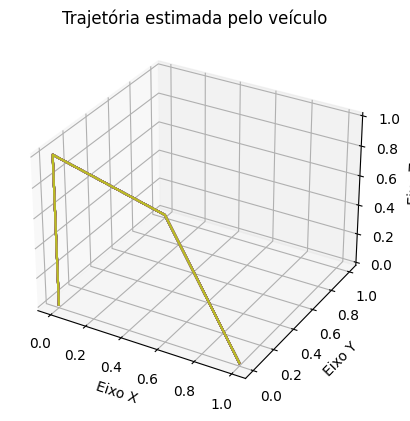

In [ ]:
# Crie uma figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Itere pelas 29 matrizes e plote a trajetória completa
for matriz in trajeto:
    x = matriz[:, 0]  # Coordenadas x dos pontos
    y = matriz[:, 1]  # Coordenadas y dos pontos
    z = matriz[:, 2]  # Coordenadas z dos pontos

    # Plote os pontos no gráfico 3D
    ax.plot(x, y, z)

# Defina os rótulos dos eixos
ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')
ax.set_zlabel('Eixo Z')
ax.set_title('Trajetória estimada pelo veículo')

# Exiba o gráfico 3D
plt.show()

## Verificação dos dados: comparando os dados reais (ground_truth) com os previstos (trajeto)

In [ ]:
# Carregando dados ground_truth:
caminho_arquivo_npy = '/content/drive/MyDrive/IA/datasets/ground_truth.npy'
dados = np.load(caminho_arquivo_npy)
print(f"Dados Reais para comparação (tamanho {len(dados)} do tipo {type(dados)})")
print(dados)

Dados Reais para comparação (tamanho 30 do tipo <class 'numpy.ndarray'>)
[[[ 1.000000e+00  9.043680e-12  2.326809e-11  5.551115e-17]
  [ 9.043683e-12  1.000000e+00  2.392370e-10  3.330669e-16]
  [ 2.326810e-11  2.392370e-10  9.999999e-01 -4.440892e-16]
  [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

 [[ 9.999978e-01  5.272628e-04 -2.066935e-03 -4.690294e-02]
  [-5.296506e-04  9.999992e-01 -1.154865e-03 -2.839928e-02]
  [ 2.066324e-03  1.155958e-03  9.999971e-01  8.586941e-01]
  [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

 [[ 9.999910e-01  1.048972e-03 -4.131348e-03 -9.374345e-02]
  [-1.058514e-03  9.999968e-01 -2.308104e-03 -5.676064e-02]
  [ 4.128913e-03  2.312456e-03  9.999887e-01  1.716275e+00]
  [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

 [[ 9.999796e-01  1.566466e-03 -6.198571e-03 -1.406429e-01]
  [-1.587952e-03  9.999927e-01 -3.462706e-03 -8.515762e-02]
  [ 6.193102e-03  3.472479e-03  9.999747e-01  2.574964e+00]
  [ 0.000000e+00  0.0

### Comparando os trajetos reais e previstos pelo ICP

### Visualmente:

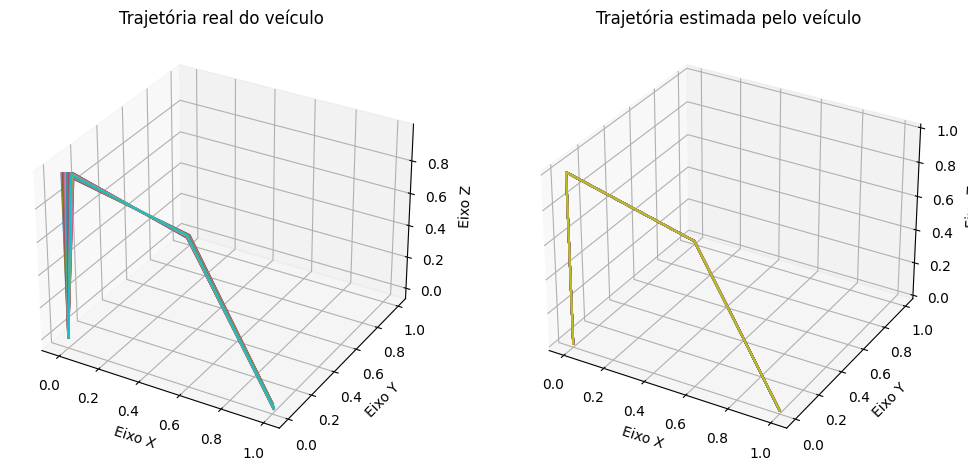

In [ ]:
# Crie uma figura 3D
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')

# Itere pelas 29 matrizes e plote a trajetória completa
for matriz in dados:
    x = matriz[:, 0]  # Coordenadas x dos pontos
    y = matriz[:, 1]  # Coordenadas y dos pontos
    z = matriz[:, 2]  # Coordenadas z dos pontos

    # Plote os pontos no gráfico 3D
    ax1.plot(x, y, z)

# Defina os rótulos dos eixos
ax1.set_xlabel('Eixo X')
ax1.set_ylabel('Eixo Y')
ax1.set_zlabel('Eixo Z')
ax1.set_title('Trajetória real do veículo')

ax2 = fig.add_subplot(122, projection='3d')

# Itere pelas 29 matrizes e plote a trajetória completa
for matriz in trajeto:
    x = matriz[:, 0]  # Coordenadas x dos pontos
    y = matriz[:, 1]  # Coordenadas y dos pontos
    z = matriz[:, 2]  # Coordenadas z dos pontos

    # Plote os pontos no gráfico 3D
    ax2.plot(x, y, z)

# Defina os rótulos dos eixos
ax2.set_xlabel('Eixo X')
ax2.set_ylabel('Eixo Y')
ax2.set_zlabel('Eixo Z')
ax2.set_title('Trajetória estimada pelo veículo')

fig.subplots_adjust(wspace=0.2)

# Exiba o gráfico 3D
plt.show()

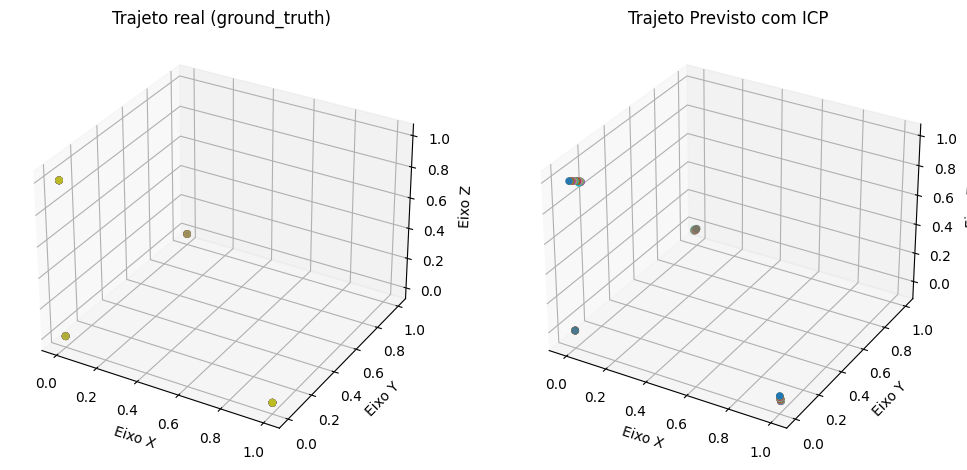

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')

for matriz in trajeto:
    x = matriz[:, 0]  # Coordenadas x dos pontos
    y = matriz[:, 1]  # Coordenadas y dos pontos
    z = matriz[:, 2]  # Coordenadas z dos pontos
    ax1.scatter(x, y, z, marker='o')  # Plote os pontos no gráfico 3D

# rótulos dos eixos
ax1.set_xlabel('Eixo X')
ax1.set_ylabel('Eixo Y')
ax1.set_zlabel('Eixo Z')
ax1.set_title("Trajeto real (ground_truth)")

# Segundo subplot
ax2 = fig.add_subplot(122, projection='3d')
for matriz in dados:
    x = matriz[:, 0]  # Coordenadas x dos pontos
    y = matriz[:, 1]  # Coordenadas y dos pontos
    z = matriz[:, 2]  # Coordenadas z dos pontos
    ax2.scatter(x, y, z, marker='o')  # Plote os pontos no gráfico 3D

# rótulos dos eixos
ax2.set_xlabel('Eixo X')
ax2.set_ylabel('Eixo Y')
ax2.set_zlabel('Eixo Z')
ax2.set_title("Trajeto Previsto com ICP")

# Ajustando a posição das subplots
fig.subplots_adjust(wspace=0.2)
plt.show()

### Analiticamente

In [ ]:
# Calcular o valor mínimo e máximo ao longo de todas as amostras e recursos
valor_minimo = np.min(dados)
valor_maximo = np.max(dados)

# Calcular o intervalo de valores reais
intervalo_valores_reais = valor_maximo - valor_minimo

print(f"Valor mínimo: {valor_minimo}")
print(f"Valor máximo: {valor_maximo}")
print(f"Intervalo de valores reais: {intervalo_valores_reais}")

Valor mínimo: -1.436633
Valor máximo: 25.59694
Intervalo de valores reais: 27.033573


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calcular o Erro Médio Absoluto (MAE)
mae = mean_absolute_error(trajeto.flatten(), dados_reduzidos.flatten())
print(f"Erro Médio Absoluto (MAE): {mae}")


Erro Médio Absoluto (MAE): 0.8310219055982832


O intervalo de valores reais pode ser uma estratégia para interpretar o resultado da métrica MAE, nesse caso, geralmente, quanto mais distante O MAE está do intervalo de valores reais, melhor a predição do algoritmo. Nesse caso, temos um Intervalo de valores reais de 27.03, enquanto o MAE tem resultado de 0.83, concluindo, portanto, que o algoritmo ICP conseguiu realizar boas previsões, pois possui um Erro Médio Absoluto baixo.

In [ ]:
# Redimensionar as matrizes para que fiquem no formato (29, 16)
trajeto_flat = trajeto.reshape(trajeto.shape[0], -1)
dados_flat = dados.reshape(dados.shape[0], -1)

# Calcular a correlação entre as matrizes
correlacao = np.corrcoef(trajeto_flat, dados_flat)[0, 1]

print(f"Correlação: {correlacao}")

Correlação: 0.99996907463232


Como podemos perceber, a partir dos varificação analitica a partir de métricas de erro e correlação, podemos verificar a similaridade dos dados reais dos dados previstos para o trajeto do veículo. Com uma correlação de 0.99 e um Erro Médio Absoluto (MAE): 0.8310219055982832 podemos apontar que sim, os dados de trajetória são semelhantes ao reais